# Part 1: Code
By Eshika Pathak, 18-10-2021

(Report and eplanations included at end)

## Downloading the dataset


In [ ]:
!pip -q install wfdb==3.4.0 
!wget -q https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip
!unzip -qo /content/mit-bih-arrhythmia-database-1.0.0.zip 

     |████████████████████████████████| 137 kB 16.8 MB/s 


## Change the ECG Signal

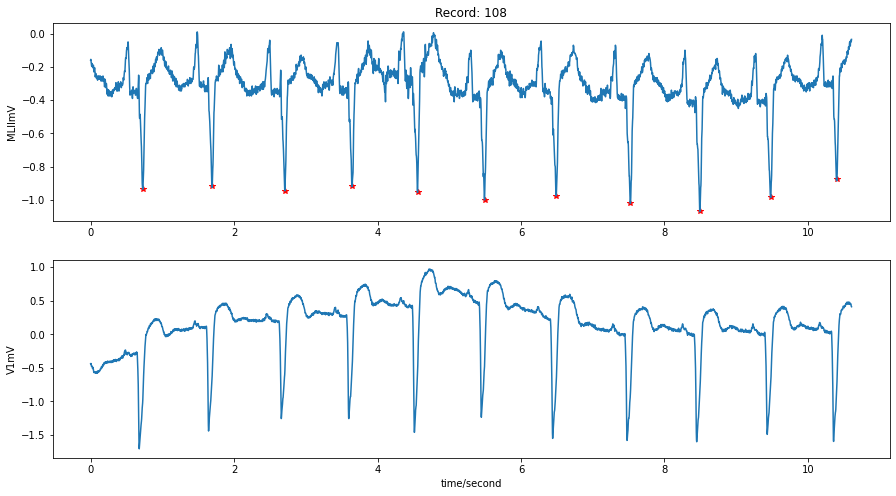

In [ ]:
#@title Choose ECG Signal { form-width: "20%", display-mode: "both" }
signal_number = 8 #@param {type:"slider", min:0, max:9, step:1}
import wfdb
import numpy as np
import pandas as pd

filename = f'/content/mit-bih-arrhythmia-database-1.0.0/{str(100 + signal_number)}'
record = wfdb.rdrecord(filename, sampfrom=180, sampto=4000,)    
annotation = wfdb.rdann(filename, 'atr', sampfrom=180, sampto=4000,shift_samps=True)

wfdb.plot_wfdb(record=record, annotation=annotation, time_units='seconds',figsize=(15,8))

## QRS Detection


In [ ]:
class Pan_Tompkins_QRS():
  
  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    [TODO] 
    This stage is necessary to remove noise from the inpput ECG signal. It improves the signal-to-noise ratio, and permits the use of lower thresholds than would be possible on the unfiltered ECG.
    I divided the band pass filter by calling two separate functions: a low pass filter and a high pass filter. For both the stages, I used the equations as exactly described in the paper. First, we apply the low pass filter
    on the input ECG signal. This is the passed to the high pass filter, giving us the final required output from an equivalent band pass filter.
    '''
    #[TODO]
    # Cascading LPF and HPF
    # LPF
    s1 = self.low_pass(signal)
    # HPF to op of LPF
    s2 = self.high_pass(s1)
    return s2

  # low pass filter
  def low_pass(self, signal):
    y = signal.copy() # creating a replica, equivalent to creating an array of same dimensions
    for n in signal.index:
      if(n < 12): # min length criteria processing, checking length of signal ip
        continue
      y.iloc[n,1] = 2*y.iloc[n-1,1] - y.iloc[n-2,1] + signal.iloc[n,1] - 2*signal.iloc[n-6,1] + signal.iloc[n-12,1] 
    return y

  # high pass filter
  def high_pass(self, signal):
    y = signal.copy() # creating a replica, equivalent to creating an array of same dimensions
    for n in signal.index:
      if(n < 32): # min length criteria processing, checking length of signal ip
        continue
      y.iloc[n,1] = y.iloc[n-1,1] - signal.iloc[n,1]/32 + signal.iloc[n-16,1] - signal.iloc[n-17,1] + signal.iloc[n-32,1]/32 #----> difference equation found in Biomedical Signal Analysis, By Rangaraj M. Rangayyan
      #y.iloc[n,1] = signal.iloc[n-16,1] - (y.iloc[n-1,1] + signal.iloc[n,1]/32 - signal.iloc[n-32,1]/32) -----> difference equation given in the paper- showing error in output
    return y


  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    [TODO] 
    After filtering, the signal is differentiated to provide the QRS-complex slope information. This is used to detect and classify peaks. This process is part of the linear transformation stage of the signal.
    I have used a five-point derivative as described in the paper. 
    '''
    #[TODO]
    y = signal.copy() # creating a replica, equivalent to creating an array of same dimensions
    for n in signal.index:
      if(n < 4): # min length criteria processing, checking length of signal ip
        continue
      y.iloc[n, 1] = (- signal.iloc[n-2-2,1] - 2*signal.iloc[n-1-2,1] + 2*signal.iloc[n+1-2,1]  + signal.iloc[n+2-2,1])/8
    return y

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    [TODO] 
    The squaring process intensifies the slope of the frequency response curve of the derivative and helps restrict false positives caused by T waves with higher than usual spectral energies. The equation is
    a simple squaring of each term. This process is part of the non linear transformation of the signal. 
    '''
    #[TODO]
    y = signal.copy() # creating a replica, equivalent to creating an array of same dimensions
    for n in signal.index:
      y.iloc[n,1] = signal.iloc[n,1]**2
    return y

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    [TODO] 
    Many abnormal QRS complexes with large amplitudes and long durations are missed in a purely derivative approach because of their relatively low R-wave slopes. 
    Thus, R-wave slope alone is insufficient for proper QRS detection. To achieve reliable performance, we must extract other parameters from the signal such as amplitude, width,
    and QRS energy. The moving window integrator produces a signal that includes information about both the slope and the width of the QRS complex.
    '''
    #[TODO]
    ws = 30 # window size, as taken in paper
    l = int(ws/2) # half of window size
    y = signal.copy() # creating a replica, equivalent to creating an array of same dimensions
    
    for n in signal.index:

      summ = 0 # initialising summation to 0 for each n
      if(n > len(signal)-ws): # can't process(sum) beyond this index 
        break
      if(n < l): # index less than half of window size
        continue
      for i in range(n-l,n+l+1): # i in range of one sample for each n
        summ = summ + signal.iloc[i,1] # equation as described in paper
      y.iloc[n,1] = summ/(l+1)	# dividing by N = number of samples in integration window

    return y

  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    We use two sets of thresholds to detect QRS complexes. One set thresholds the filtered ECG, and the other thresholds the signal produced by moving window integration. 
    By using thresholds on both signals, we improve the reliability of detection compared to using one waveform alone. "There are two separate threshold levels in each of the two sets of thresholds. 
    One level is half of the other. The thresholds continuously adapt to the characteristics of the signal since they are based upon the most-recent signal and noise peaks that are detected in the
    ongoing processed signals.
    If the program does not find a QRS complex in the time interval corresponding to 166 percent of the current average RR interval, the maximal peak detected in
    that time interval that lies between these two thresholds is considered to be a possible QRS complex, and the lower of the two thresholds is applied. For the case of irregular heart rates, both thresholds are reduced
    by half in order to increase the sensitivity of detection and to avoid missing valid beats."
    Once a valid QRS complex is recognized, there is a 200 ms refractory period before the next one can be detected since QRS complexes cannot occur more closely than this physiologically. 
    This refractory period eliminates the possiblity of a false detection such as multiple triggering on the same QRS complex during this time interval.
    The lower threshold is used if no QRS is detected in a certain time interval so that a search-back technique is necessary to look back in time for the QRS complex.
    To be a signal peak, the peak must exceed THRESHOLD I1 as the signal is first analyzed or THRESHOLD 12 if searchback is required to find the QRS.

    step 1: find the noise signal by subtracting op of bandpass from original ecg (hpf anf lpf of gain 32 and 36 were applied, therefore dividing)
    step 2: set of thresholds applied to the integration waveform is computed
            2.1 : finding filtered signal peaks and updating thresholds
            2.2 : checking classification as a signal peak using T1 initially then T2

    step 3: set of thresholds applied to the filtered ECG is determined- using RR_missed acc to paper
            3.1 : finding filtered signal peaks and updating thresholds
            3.2 : checking classification as a signal peak using T1 initially then T2

    step 4: checking if: To be identified as a QRS complex, a peak must be recognized as such a complex in both the integration and bandpass-filtered waveforms.
            This method is not fully implemented because the location of peaks differe for the two signals due to different waveforms.

    step 5: checking missed peaks using RR_Missed Limit

    [TODO] 
    '''
    #[TODO]
    # op of BPF:
    s1 = self.band_pass_filter(signal)
    # taking derivative
    s2 = self.derivative(s1)
    # squaring the signal
    s3 = self.squaring(s2)
    # moving window integration
    s4 = self.moving_window_integration(s3)
    #print(s4)

    # step 1: find the noise signal by subtracting op of bandpass from original ecg (hpf anf lpf of gain 32 and 36 respectively were applied, therefore dividing)
    snoise = signal - (s1/(36*32))

    # -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # step 2: thresholds and detection on integration waveform (s4)

    # i stands for initial thresholds

    # 2.1 finding filtered signal peaks and updating thresholds
    peak_i_signal = 0 # initialising overall peak of signal
    peak_i_noise = 0 # initialising overall peak of signal
    #print("pf",type(peak_i))
    spk_i = peak_i_signal # running estimate of signal peak
    npk_i = peak_i_noise # running estimate of noise peak
    # print(spk_i, npk_i)
    peak_index_i = [0] # array to store index of peaks
    threshold1_i = spk_i # starting value therehold 1 = 0
    peak_details_i = [] # empty array to store volt and position details of all detected peaks of integration waveform

    if signal_number==8: # for signal 8, the starting noise is very high, so we start from an index >1
      ind = 10
    else:
      ind = 1

    for i in range(ind,len(s4.iloc[:,1])):
        if s4.iloc[i,1]>peak_i_signal:
            peak_i_signal = s4.iloc[i,1] # updating the overall signal maxima

        if snoise.iloc[i,1]>peak_i_noise:
            peak_i_noise = snoise.iloc[i,1] # updating the overall noise maxima
      
        # updating threshold
        npk_i = 0.125*peak_i_noise + 0.875*npk_i 
        spk_i = 0.125*peak_i_signal + 0.875*spk_i 
        
        # formulas as given in paper
        threshold1_i = npk_i + 0.25*(spk_i-npk_i)
        threshold2_i = 0.5 * threshold1_i

        if(s4.iloc[i,1]>=threshold1_i):
          if(peak_index_i[-1]+200<i): # there is a 200 ms refractory period before the next one can be detected since QRS complexes cannot occur more closely than this physiologically.
                  peak_index_i.append(i) # saving peak index
                  peak_details_i.append([s4.iloc[i,0], s4.iloc[i,1]]) # storing voltage and position details of detected peak
        else: # search back
          # 2.2: To be a signal peak, the peak must exceed THRESHOLD I1 as the signal is first analyzed or THRESHOLD 12 if searchback is required to find the QRS.
          if(s4.iloc[i,1]>=threshold2_i):
              # checking if point lies in indexable range, then saving it as a peak
              # checking if the new peak lies atleast a 200ms away from previous peak
              if(peak_index_i[-1]+200<i): # there is a 200 ms refractory period before the next one can be detected since QRS complexes cannot occur more closely than this physiologically.
                  peak_index_i.append(i) # saving peak index
                  peak_details_i.append([s4.iloc[i,0], s4.iloc[i,1]]) # storing voltage and position details of detected peak
                  spk_i = 0.25*peak_i_signal + 0.75*spk_i # updating spk_i when search back implemented
                
    print("STEP 2: thresholds and detection on integration waveform (s4)")
    print("Step 2: npk_i: ",npk_i)
    print("Step 2: spk_i: ",spk_i)
    print("Step 2: Threshold 1_i: ",threshold1_i)
    print("Step 2: Threshold 2_i: ",threshold2_i)
    print("Step 2: Number of peaks is: ",len(peak_index_i))
    # -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # step 3: thresholds and detection on bpf output (s1)

    # f stands for final thresholding

    s1.iloc[:,1] = s1.iloc[:,1] + abs(min(s1.iloc[:,1])) # BPF op is in negative volts due to phase shift, makig it positive in order to find the peaks
    peak_f_signal = 0 # initialising overall peak of signal
    peak_f_noise = 0 # initialising overall peak of signal
    spk_f = peak_f_signal # running estimate of signal peak
    npk_f = peak_f_noise # running estimate of noise peak
    peak_index_f = [0] # array to store index of peaks
    threshold1_f = spk_f # starting value therehold 1 = 0
    peak_details_f = [] # empty array to store volt and position details of all detected peaks of filtered ecg

    for i in range(1,len(s1.iloc[:,1])):
          if s1.iloc[i,1]>peak_f_signal:
              peak_f_signal = s1.iloc[i,1] # updating the overall signal maxima

          if snoise.iloc[i,1]>peak_f_noise:
              peak_f_noise = snoise.iloc[i,1] # updating the overall noise maxima
        
          # updating threshold
          npk_f = 0.125*peak_f_noise + 0.875*npk_f
          spk_f = 0.125*peak_f_signal + 0.875*spk_f 
          
          # formulas as given in paper
          threshold1_f = npk_f + 0.25*(spk_f-npk_f)
          threshold2_f = 0.5 * threshold1_f

          if(s1.iloc[i,1]>=threshold1_f):
            if(peak_index_f[-1]+200<i): # there is a 200 ms refractory period before the next one can be detected since QRS complexes cannot occur more closely than this physiologically.
                    peak_index_f.append(i) # saving peak index
                    peak_details_f.append([s1.iloc[i,0], s1.iloc[i,1]]) # storing voltage and position details of detected peak
          else: # search back
            # 2.2: To be a signal peak, the peak must exceed THRESHOLD I1 as the signal is first analyzed or THRESHOLD 12 if searchback is required to find the QRS.
            if(s1.iloc[i,1]>=threshold2_f):
                # checking if point lies in indexable range, then saving it as a peak
                # checking if the new peak lies atleast a 200ms away from previous peak
                if(peak_index_f[-1]+200<i): # there is a 200 ms refractory period before the next one can be detected since QRS complexes cannot occur more closely than this physiologically.
                    peak_index_f.append(i) # saving peak index
                    peak_details_f.append([s1.iloc[i,0], s1.iloc[i,1]]) # storing voltage and position details of detected peak
                    spk_f = 0.25*peak_f_signal + 0.75*spk_f # updating spk_i when search back implemented

    print("STEP 3: thresholds and detection on bpf output (s1)")                          
    print("Step 3: npk_f: ",npk_f)
    print("Step 3: spk_f: ",spk_f)
    print("Step 3: Threshold 1_f: ",threshold1_f)
    print("Step 3: Threshold 2_f: ",threshold2_f)
    print("Step 3: Number of peaks is: ",len(peak_index_f))

    # -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # step 4: checking common peaks
    # This method is not fully implemented because the location of peaks differe for the two signals due to different waveforms.

    print(peak_details_f)
    print(peak_details_i)
    i_x = []
    i_y = []
    for i in range(1,len(peak_details_i)):
      i_x.append(peak_details_i[i][0])
      i_y.append(peak_details_i[i][1])
    f_x = []
    f_y = []
    for i in range(1,len(peak_details_f)):
      f_x.append(peak_details_f[i][0])
      f_y.append(peak_details_f[i][1])
    
    if len(i_x)<=2:
      peak_details_i = peak_details_f
    if len(i_x)<len(f_x):
      op1 = i_x # shorter
      op2 = f_x
      op3 = i_y
      op4 = f_y
    else:
      op1 = f_x # shorter
      op2 = i_x
      op3 = f_y
      op4 = i_y
    
    final_x = []
    final_y = []
    for i in range(1, len(op1)):
      if (op1[i]+100 in op2) or (op1[i]-100 in op2): # permitting some offset error in two peaks
        final_x.append(op1[i])
        final_y.append(op3[i])
      #else:
        #print("no common")

    #print(final_x, final_y)
    
    # -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # step 5: checking missed peaks using RR_MISSED LIMIT

    threshold1_f = 0
    threshold2_f = 0
    peak_f_signal = s4.iloc[0,1] # initialising
    spk_f = 0
    npk_f = 0
    peak_index_f = peak_index_i
    avg = np.average(np.diff(peak_index_i)) # RR_average
    peak_details_f = peak_details_i # empty array to store volt and position details of all detected peaks of filtered ecg
    peak_index_missed = []

    for i in range(1,len(peak_index_f)):
        peak_f = s4.iloc[i-1,1] # setting most recent maxima
        if(peak_index_f[i]-peak_index_f[i-1]>=1.66*avg): # looking for missed peaks in s4, using RR_missed limit
            for j in range(int(peak_index_f[i-1])+1,int(peak_index_f[i])):
                if s1.iloc[j,1]>peak_f_signal:
                    peak_f_signal = s1.iloc[j,1] # updating the overall signal maxima

                if snoise.iloc[j,1]>peak_f_noise:
                    peak_f_noise = snoise.iloc[j,1] # updating the overall noise maxima
              
                # updating threshold
                npk_f = 0.125*peak_f_noise + 0.875*npk_f
                spk_f = 0.125*peak_f_signal + 0.875*spk_f 
                
                # formulas as given in paper
                threshold1_f = npk_f + 0.25*(spk_f-npk_f)
                threshold2_f = 0.5 * threshold1_f

                if(s4.iloc[j,1]>=threshold1_i):
                  if(peak_index_f[-1]+200<j): # there is a 200 ms refractory period before the next one can be detected since QRS complexes cannot occur more closely than this physiologically.
                          peak_index_f.append(j) # saving peak index
                          peak_details_f.append([s4.iloc[j,0], s4.iloc[j,1]]) # storing voltage and position details of detected peak
                else:
                  if(s4.iloc[j,1]>=threshold2_f):
                      if(peak_index_f[-1] < j):
                          peak_index_missed.append(j)
                          peak_index_f.append(j)
                          peak_details_f.append(s4.iloc[j,1])

    print("STEP 5: Checking missed peaks using RR_MISSED LIMIT")             
    print("Step 5: npk_f: ",npk_f)
    print("Step 5: spk_f: ",spk_f)
    print("Step 5: Threshold 1_f: ",threshold1_f)
    print("Step 5: Threshold 2_f: ",threshold2_f)
    print("Step 5: Number of missed peaks is: ",len(peak_index_missed))

    return peak_details_f

QRS_detector = Pan_Tompkins_QRS()
ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])
output_signal = QRS_detector.solve(ecg)

STEP 2: thresholds and detection on integration waveform (s4)
Step 2: npk_i:  1025.355333116318
Step 2: spk_i:  245841.55664062494
Step 2: Threshold 1_i:  62229.40565999348
Step 2: Threshold 2_i:  31114.70282999674
Step 2: Number of peaks is:  12
STEP 3: thresholds and detection on bpf output (s1)
Step 3: npk_f:  1025.355333116318
Step 3: spk_f:  2987.5624999999986
Step 3: Threshold 1_f:  1515.9071248372381
Step 3: Threshold 2_f:  757.9535624186191
Step 3: Number of peaks is:  20
[[201, 2277.78125], [402, 1852.9375], [603, 2061.375], [804, 1861.8125], [1005, 2047.46875], [1206, 1871.375], [1407, 1873.4375], [1608, 1670.0], [1809, 1974.25], [2010, 2635.1875], [2211, 1915.25], [2412, 1783.15625], [2613, 1944.78125], [2814, 1931.53125], [3015, 1394.59375], [3216, 1881.1875], [3417, 2305.59375], [3618, 1898.40625], [3819, 1859.25]]
[[267, 33236.4031791687], [617, 31217.516850471497], [980, 32036.8497505188], [1323, 31875.433165550232], [1653, 31817.915596961975], [1990, 32089.696544647217]

## Plotting the Signals


STEP 2: thresholds and detection on integration waveform (s4)
Step 2: npk_i:  1025.355333116318
Step 2: spk_i:  245841.55664062494
Step 2: Threshold 1_i:  62229.40565999348
Step 2: Threshold 2_i:  31114.70282999674
Step 2: Number of peaks is:  12
STEP 3: thresholds and detection on bpf output (s1)
Step 3: npk_f:  1025.355333116318
Step 3: spk_f:  2987.5624999999986
Step 3: Threshold 1_f:  1515.9071248372381
Step 3: Threshold 2_f:  757.9535624186191
Step 3: Number of peaks is:  20
[[201, 2277.78125], [402, 1852.9375], [603, 2061.375], [804, 1861.8125], [1005, 2047.46875], [1206, 1871.375], [1407, 1873.4375], [1608, 1670.0], [1809, 1974.25], [2010, 2635.1875], [2211, 1915.25], [2412, 1783.15625], [2613, 1944.78125], [2814, 1931.53125], [3015, 1394.59375], [3216, 1881.1875], [3417, 2305.59375], [3618, 1898.40625], [3819, 1859.25]]
[[267, 33236.4031791687], [617, 31217.516850471497], [980, 32036.8497505188], [1323, 31875.433165550232], [1653, 31817.915596961975], [1990, 32089.696544647217]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


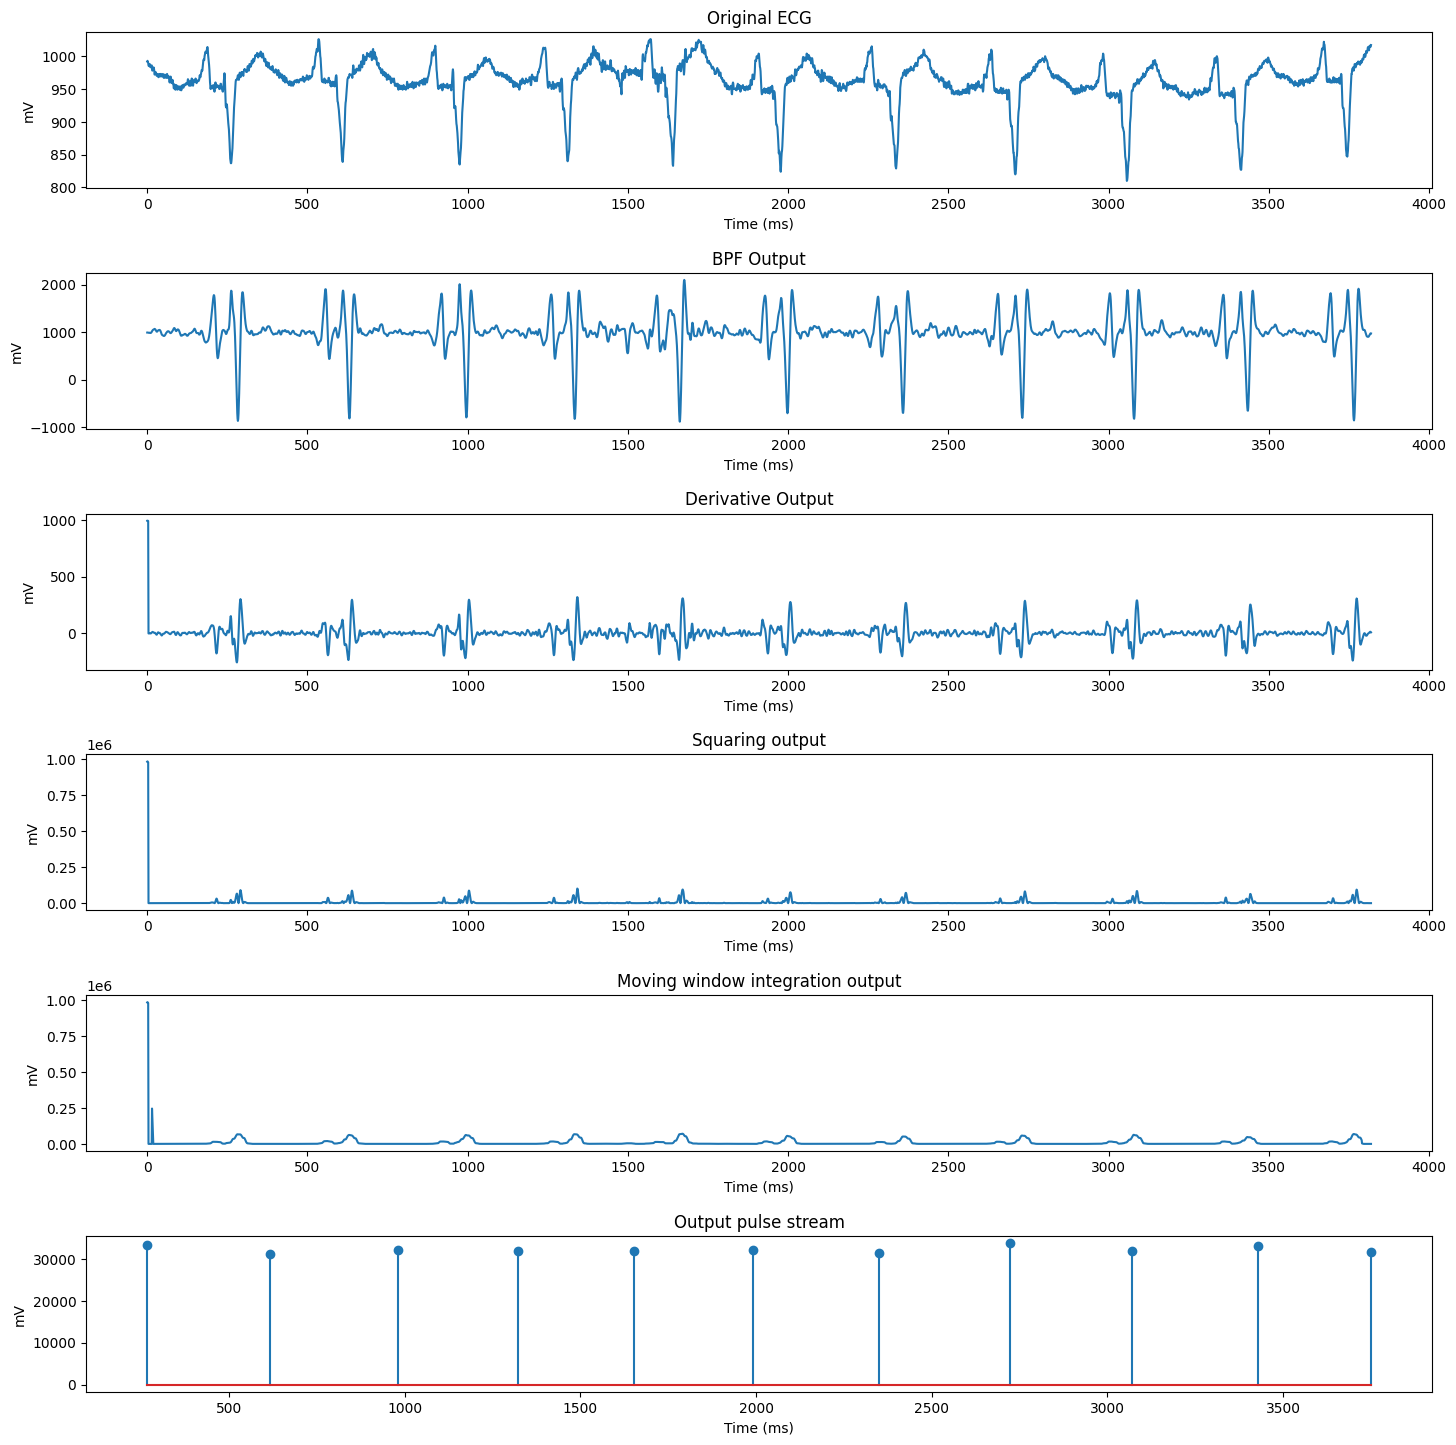

In [ ]:
import matplotlib.pyplot as plt

QRS_detector = Pan_Tompkins_QRS()
ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])

# op of BPF:
s1 = QRS_detector.band_pass_filter(ecg)
# taking derivative
s2 = QRS_detector.derivative(s1)
# squaring the signal
s3 = QRS_detector.squaring(s2)
# moving window integration
s4 = QRS_detector.moving_window_integration(s3)
# output pulse stream
output_signal = QRS_detector.solve(ecg)
op_x = []
op_y = []
for i in range(0,len(output_signal)):
  #print(output_signal[i][0])
  op_x.append(output_signal[i][0])
  op_y.append(output_signal[i][1])

# figure canvas: 5 subplots for the 5 steps
fig = plt.figure(figsize = (15,15))
fig.set_dpi(100)
#fig.suptitle("Wave Outputs: X axis: time (ms), Y axis: milli-volts") # figure heading
ax1 = fig.add_subplot(6,1,1)
ax2 = fig.add_subplot(6,1,2)
ax3 = fig.add_subplot(6,1,3)
ax4 = fig.add_subplot(6,1,4)
ax5 = fig.add_subplot(6,1,5)
ax6 = fig.add_subplot(6,1,6)
fig.tight_layout(pad=4) # display layout setting

#plt.figure(figsize=(15,8)) 
ax1.plot(ecg.iloc[:,0], ecg.iloc[:,1])
ax1.set_title('Original ECG')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('mV')

ax2.plot(s1.iloc[:,0], s1.iloc[:,1])
ax2.set_title('BPF Output')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('mV')

ax3.plot(s2.iloc[:,0], s2.iloc[:,1])
ax3.set_title('Derivative Output')
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('mV')

ax4.plot(s3.iloc[:,0], s3.iloc[:,1])
ax4.set_title('Squaring output')
ax4.set_xlabel('Time (ms)')
ax4.set_ylabel('mV')

ax5.plot(s4.iloc[:,0], s4.iloc[:,1])
ax5.set_title('Moving window integration output')
ax5.set_xlabel('Time (ms)')
ax5.set_ylabel('mV')

ax6.stem(op_x, op_y)
ax6.set_title('Output pulse stream')
ax6.set_xlabel('Time (ms)')
ax6.set_ylabel('mV')

plt.show()

## Calculating the heart rate


In [ ]:
'''
Two separate measurements of the average RR interval are maintained. One RR-interval average is the mean of all of the most recent eight RR intervals. 
A second RR -interval average is the mean of the most recent eight beats that fell within the range of 92-116 percent of the current RR-interval average. Without this first average, 
this approach would be suitable only for a slowly changing and regular heart rate. When the heart rate suddenly changes, the first RR-interval average substitutes for the second one.
This heart rate is now in terms of a time period. We then convert it to beats per minute.
'''


heart_rate = np.ndarray(np.size(op_x)-1)
for i in range(1,len(op_x)):
    heart_rate[i-1] = (op_x[i]-op_x[i-1])

heart_beat = heart_rate
#heart_beat = (1/heart_rate) * 60 # (BPM)

count = 8
RR_avg1 = np.average(heart_rate[-8:])
#print(RR_avg1)
RR_avg2 = 0

for i in range(1,len(heart_rate)):
    if heart_rate[-1*i] > 200:
        count = count-1
        RR_avg2 = RR_avg2 + heart_rate[-1*i]
    if count == 0:
        break # taking in sets of 8
RR_avg2 = 0.125*RR_avg2
#print(RR_avg2)

RR_low_limit = 0.92 * RR_avg2
RR_high_limit = 1.16 * RR_avg2
#print(RR_low_limit, RR_high_limit)
RR_avg_op = 60*1000/(2*RR_avg1) #bpm
if RR_avg1<=RR_high_limit and RR_avg1 >= RR_low_limit:
    print("Normal sinus with average heart beat (bpm)", RR_avg_op)
else:
    print("Not a normal sinus with average heart beat (bpm)", RR_avg_op)

Normal sinus with average heart beat (bpm) 86.64259927797833


# Part 2: Report

## Understanding of the Algorithm


*References:*
1.   *J. Pan and W. J. Tompkins, "A Real-Time QRS Detection Algorithm," in IEEE Transactions on Biomedical Engineering, vol. BME-32, no. 3, pp. 230-236, March 1985, doi: 10.1109/TBME.1985.325532.*
2.   *Biomedical Signal Analysis, By Rangaraj M. Rangayyan*

First, let us understand what a QRS complex is by looking at the following ECG (electrocardiogram) diagram (image source: Wikipedia)-

![ECG Beat](https://drive.google.com/uc?export=view&id=1Ngy7ODM2WPpScmzIXqowqiJuRZTlb5bU)

Our task is to identify the QRS complaxes and find the heart beat using the RR interval (the time elapsed between two successive R-waves of the QRS signal on the ECG).

Software QRS detectors typically include three different types of processing steps: linear digital filtering, nonlinear transformation, and decision rule algorithms. The Pan Tompkins method uses all three components. The linear processes include a bandpass filter, a derivative, and a moving window integrator. The nonlinear transformation is signal amplitude squaring. Adaptive thresholds form the decision rule algorithm.
The following is the block diagram for the Pan Tompkins process (image source: Wikipedia)-

![Block Diagram](https://drive.google.com/uc?export=view&id=16u1l2xPdTz3OysrZbUOYP_Y304ISHPGC)

**STAGE 1: Linear digital filtering: Band pass filter**

This stage is necessary to remove noise from the input ECG signal. It improves the signal-to-noise ratio, and permits the use of lower thresholds than would be possible on the unfiltered ECG. We divide the band pass filter by calling two separate functions: a low pass filter and a high pass filter. For both the stages, the paper states the difference equations. First, we apply the low pass filter on the input ECG signal. This is the passed to the high pass filter, giving us the final required output from an equivalent band pass filter. The order of applying the filters does not matter. 
The gain of the HPF is 32 V/V while that of the LPF is 36 V/V. 

**STAGE 2: Finding the derivative**

After filtering, the signal is differentiated to provide the QRS-complex slope information. This is used to detect and classify signal and noise peaks after further processing. This process is part of the linear transformation stage of the signal. I have used a five-point derivative as described in the paper. 

**STAGE 3: Squaring**

The squaring process intensifies the slope of the frequency response curve of the derivative and helps restrict false positives caused by T waves with higher than usual spectral energies. The equation is a simple squaring of each term. This process is part of the non linear transformation of the signal.

**STAGE 4: Moving window integration**

Many abnormal QRS complexes with large amplitudes and long durations are missed in a purely derivative approach because of their relatively low R-wave slopes. Therefore, R-wave slope alone is insufficient for proper QRS detection. To achieve reliable performance, we extract other parameters from the signal such as amplitude, width, and QRS energy. The moving window integrator produces a signal that includes information about both the slope and the width of the QRS complex.

**STAGE 5: Adaptive thresholding**

The algorithm uses two sets of thresholds to detect QRS complexes. One set thresholds the filtered ECG, and the other thresholds the signal produced by moving window integration. 

By using thresholds on both signals, we improve the reliability of detection compared to using one waveform alone. For each of the two signals, we have to seperate thresholds (one is half of the other). The thresholds continuously adapt to the characteristics of the signal since they are based upon the most-recent signal and noise peaks that are detected in the signal.

RR interval is defined as the time interval between two consecutive R waves, i.e peaks. If the program does not find a QRS complex in the time interval corresponding to 166 percent of the current average RR interval, the maximal peak detected in that time interval that lies between these two thresholds is considered to be a possible QRS complex, and the lower of the two thresholds is applied. For the case of irregular heart rates, both thresholds are reduced by half in order to increase the sensitivity of detection and to avoid missing valid beats.

Once a valid QRS complex is recognized, there is a 200 ms refractory period before the next one can be detected since QRS complexes cannot occur more closely than this physiologically. This refractory period eliminates the possiblity of a false detection such as multiple triggering on the same QRS complex during this time interval.

There are tow possibilities while detecting peaks- while searching forward and search back. While searching forward, the higher threshold is used. The lower threshold is used if no QRS is detected in a certain time interval so that a search-back technique is necessary to look back in time for the QRS complex. 

    step 1: find the noise signal by subtracting op of bandpass from original ecg (hpf anf lpf of gain 32 and 36 were applied, therefore dividing)
    step 2: set of thresholds applied to the integration waveform is computed
            2.1 : finding filtered signal peaks and updating thresholds
            2.2 : checking classification as a signal peak using T1 initially then T2 if search back required

    step 3: set of thresholds applied to the filtered ECG is determined- using RR_missed acc to paper
            3.1 : finding filtered signal peaks and updating thresholds
            3.2 : checking classification as a signal peak using T1 initially then T2 if search back required

    step 4: checking if: To be identified as a QRS complex, a peak must be recognized as such a complex in both the integration and bandpass-filtered waveforms. 
    This method is not fully implemented because the location of peaks differe for the two signals due to different waveforms.

    step 5: checking missed peaks using RR_Missed Limit

**STAGE 6: Finding the heart rate**

The algorithm maintains two separate measurements of the average RR interval. One RR interval average is the mean of all of the most recent eight RR intervals. A second RR interval average is the mean of the most recent eight beats that fell within the range of 92-116% of the current RR interval average. "Without this first average, this approach would be suitable only for a slowly changing and regular heart rate. When the heart rate suddenly changes, the first RR-interval average substitutes for the second one." We calculate RR upper and lower limits and use this to classify the beats as normal and not normal sinus rhythm.
The heart rate is now in terms of a time period. We then convert it to beats per minute.

## Results


The following are the plots and heart rate results for each signal (0-9) of the data set
Output wave forms from the research paper-
![Pan Tompkins](https://i.ibb.co/3C6r4qP/results-eg.png)

**Signal 0:** 

Normal sinus with average heart beat (bpm) 102.25820195994888
![signal_0](https://drive.google.com/uc?export=view&id=1MVVQZCYwYKPdzc4Q3uk1_cuivfarpSPL)


**Signal 1:** 

Normal sinus with average heart beat (bpm) 92.5925925925926

![signal_1](https://drive.google.com/uc?export=view&id=13gUTvECffshhLaF000Y6HjLHOsU6XieA)

**Signal 2:** 

Normal sinus with average heart beat (bpm) 100.50251256281408
![signal_2](https://drive.google.com/uc?export=view&id=1KIHla-BjrQbZrEB5Gj7xoXQOcMMoudfj)

**Signal 3:**

Normal sinus with average heart beat (bpm) 97.0873786407767
![signal_2](https://drive.google.com/uc?export=view&id=1IqHm1fwXRTcn3JLG71G-KnmN5983P6RH)

**Signal 4:**

Normal sinus with average heart beat (bpm) 103.31467929401636
![signal_4](https://drive.google.com/uc?export=view&id=1TLBc6bUrRIkiLbEqBtUijIGjvj-oM3Hm)

**Signal 5:**

Normal sinus with average heart beat (bpm) 114.61318051575931
![signal_5](https://drive.google.com/uc?export=view&id=1timNFrjbTM-WuzLzSA2dkHmaC0PXfeRY)



**Signal 6**

Normal sinus with average heart beat (bpm) 84.38818565400844
![signal_6](https://drive.google.com/uc?export=view&id=1iwplC4QWZMDVsdHyyXtL_e1f-4ScX4xz)


**Signal 7**

Normal sinus with average heart beat (bpm) 97.87928221859707
![signal_7](https://drive.google.com/uc?export=view&id=1WdviA_36iSeAwl3UOcYVO48WtVQEySC4)

**Signal 8**

Normal sinus with average heart beat (bpm) 86.64259927797833
![signal_8](https://drive.google.com/uc?export=view&id=1G9ZXyLZJpWxL6w7C-lxgwjkLtlvNg549)


**Signal 9**

Normal sinus with average heart beat (bpm) 131.57894736842104
![signal_9](https://drive.google.com/uc?export=view&id=16tMcr0-U-AK5f6potS66zTjJUbu-r8i4)

## Conclusion


We have successfully implemented a QRS detection algorithm using Python's fundamental libraries. We use an input ECG's slope, amplitude and width information to detect peaks and thereby detect QRS complexes. We check our results by using adaptive thresholding on the filtered ECG (low signal-to-noise ratio) and the output of the moving integration window. Additionally, using adaptive thresholding enables high senstivity, and using search back improves accuracy in detection. The thresholds continuously adapt to the characteristics of the signal since they are based upon the most-recent signal and noise peaks that are detected in the signal. For example, signal 8 of the data set has very high initial noise, which limits the capabilities of the method using integration wave form alone. However, the adaptive thresholding form a point after the initial data, enables us to accurately detect following QRS complexes. The method descibed in the paper also allows us to work with ECG signals with irregular heart rate changes. 

By analysing RR intervals, we are also able to comment if the heart beats follow a normal sinus rhythm or not. This algorithm has vast applications in abnormality detection and also heart rate monitoring systems used in hospitals today. We can make further improvements to this algorithm by introducing efficient thresholding using learning algorithms. This can improve the accuracy and reduce the computation time of the detection algorithm. 